# Data Scientist Professional Case Study

### Company Background

Nearly New Nautical is a website that allows users to advertise their used boats for sale. When users list their boat, they have to provide a range of information about their boat. Boats that get lots of views bring more traffic to the website, and more potential customers. 

To boost traffic to the website, the product manager wants to prevent listing boats that do not receive many views.




### Customer Question

The product manager wants to know the following:
- Can you predict the number of views a listing will receive based on the boat's features?



### Success Criteria

The product manager would consider using your model if, on average, the predictions were only 50% off of the true number of views a listing would receive.


### Dataset

The data you will use for this analysis can be accessed here: `"data/boat_data.csv"`

# Data and its characteristics  
Price                		:Character, boat price listed in different currencies (e.g. EUR, Â£,
                     			CHF etc.) on the website  

Boat Type            		:Character, type of the boat  

Manufacturer          		:Character, manufacturer of the boat  

Type :Character condition of the boat and engine type(e.g. Diesel,
                                     Unleaded, etc.)  

Year Built :Numeric year of the boat built  

Length :Numeric length in meter of the boat  

Width :Numeric width in meter of the boat  

Material :Character  material of the boat (e.g. GRP, PVC, etc.)  

Location            		:Character location of the boat is listed  

Number of views last 7      :Numeric, number of the views of the list last 7 days  
days


# Import relevant libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('colorblind')
sns.set_style('darkgrid')
sns.set()
from sklearn.preprocessing import StandardScaler, LabelEncoder
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV

In [2]:
# Load the dataset
raw_data = pd.read_csv('data/boat_data.csv')
raw_data.head()

,Price,Boat Type,Manufacturer,Type,Year Built,Length,Width,Material,Location,Number of views last 7 days
0,CHF 3337,Motor Yacht,Rigiflex power boats,new boat from stock,2017,4.00,1.90,NaN,Switzerland Â» Lake Geneva Â» VÃ©senaz,226
1,EUR 3490,Center console boat,Terhi power boats,new boat from stock,2020,4.00,1.50,Thermoplastic,Germany Â» BÃ¶nningstedt,75
2,CHF 3770,Sport Boat,Marine power boats,new boat from stock,0,3.69,1.42,Aluminium,Switzerland Â» Lake of Zurich Â» StÃ¤fa ZH,124
3,DKK 25900,Sport Boat,Pioner power boats,new boat from stock,2020,3.00,1.00,NaN,Denmark Â» Svendborg,64
4,EUR 3399,Fishing Boat,Linder power boats,new boat from stock,2019,3.55,1.46,Aluminium,Germany Â» Bayern Â» MÃ¼nchen,58


In [3]:
# Get data info
print(raw_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9888 entries, 0 to 9887
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Price                        9888 non-null   object 
 1   Boat Type                    9888 non-null   object 
 2   Manufacturer                 8550 non-null   object 
 3   Type                         9882 non-null   object 
 4   Year Built                   9888 non-null   int64  
 5   Length                       9879 non-null   float64
 6   Width                        9832 non-null   float64
 7   Material                     8139 non-null   object 
 8   Location                     9852 non-null   object 
 9   Number of views last 7 days  9888 non-null   int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 772.6+ KB
None


**Observation**
* There are missing values in the data
* The price column is a string, it represents the price in different currencies
* The year column has a value of 0, which isn't possible, so the values represent missing values

In [4]:
# Checking the price column
price_df = raw_data['Price'].str.split(' ', expand = True)
price_df.head()

,0,1
0,CHF,3337
1,EUR,3490
2,CHF,3770
3,DKK,25900
4,EUR,3399


In [5]:
# Getting the total numbers of currency
price_df[0].unique()

array(['CHF', 'EUR', 'DKK', 'Â£'], dtype=object)

**Observation**
* There are four different currencies, They must be made uniform, hence all the price will be converted to USD
* The current exchange rate to USD are:
    * 1 CHF = 1 dollar
    * 1 EUR = 0.98 dollar
    * 1 DKK = 0.13 dollar
    * 1 £ = 1.14 dollar
* First we convert the prices to float type

In [6]:
# Changing the prices to a float
price_df[1] = price_df[1].astype(np.float64)
# Currencies list
currencies = ['CHF', 'EUR', 'DKK', 'Â£']
# Exchange rate 
convert = [1, 0.98, 0.13, 1.14]
# Changing all to USD using a loop
for i in range(4):
    price_df[1] = np.where(price_df[0]==currencies[i], price_df[1]*convert[i], price_df[1])

In [7]:
# Create a checkpoint
data1 = raw_data.copy()
# Now put in place of price in the data
data1['Price'] = price_df[1]

In [8]:
# Checking the number of unique values in boat type
data1['Boat Type'].nunique()

126

In [9]:
# Checking the value_count of the first 20
data1['Boat Type'].value_counts()[:20]

Motor Yacht            2720
Sport Boat             1407
Flybridge              1194
Trawler                 679
Pilothouse              613
Cabin Boat              585
Hardtop                 507
Center console boat     369
Bowrider                301
Deck Boat               283
Fishing Boat            173
House Boat              145
Mega Yacht              108
Pontoon Boat             91
Runabout                 73
Classic                  59
Classic,Runabout         59
Wakeboard/Wakesurf       58
Launch                   55
Offshore Boat            54
Name: Boat Type, dtype: int64

**Observation**
* The first 20 data contains almost all the data
* For boat type not in the first 20, they will be categorized as others

In [10]:
# create a list of the top 20
top_20 = list(data1['Boat Type'].value_counts()[:20].index)
mask_not_top_20 = ~ data1['Boat Type'].isin(top_20)
data1['Boat Type'] = np.where(mask_not_top_20, 'Others', data1['Boat Type'])
data1['Boat Type'].nunique()

21

In [11]:
data1['Boat Type'].value_counts()

Motor Yacht            2720
Sport Boat             1407
Flybridge              1194
Trawler                 679
Pilothouse              613
Cabin Boat              585
Hardtop                 507
Center console boat     369
Others                  355
Bowrider                301
Deck Boat               283
Fishing Boat            173
House Boat              145
Mega Yacht              108
Pontoon Boat             91
Runabout                 73
Classic,Runabout         59
Classic                  59
Wakeboard/Wakesurf       58
Launch                   55
Offshore Boat            54
Name: Boat Type, dtype: int64

In [12]:
# Checking the counts of the 20 manufacturers
print(data1['Manufacturer'].value_counts()[:20])
print('\n')
data1['Manufacturer'].nunique()

BÃ©nÃ©teau power boats                        631
Jeanneau power boats                          537
Sunseeker power boats                         383
Princess power boats                          241
Sea Ray power boats                           239
Cranchi power boats                           219
Azimut power boats                            215
Bavaria power boats                           185
Fairline power boats                          172
Quicksilver (Brunswick Marine) power boats    167
Sessa power boats                             148
Bayliner power boats                          142
Sealine power boats                           120
Quicksilver power boats                       118
Prestige Yachts power boats                   108
Galeon power boats                             94
Regal power boats                              90
Riva power boats                               77
Linssen power boats                            70
Windy power boats                              64


910

**Observation**
* The number of unique values are 910
* The Manufacturer all have power boats in them, it should be dropped for just the Manufacturer name
* The name will be changed to lower case, just in case there are names, written in different cases

In [13]:
# Changing all names to lower cases
data1['Manufacturer'] = data1['Manufacturer'].str.lower()
data1['Manufacturer'] = data1['Manufacturer'].str.replace(' power boats', '')
data1['Manufacturer'].nunique()

909

In [14]:
# Get the numbers of Manufacturer that has 0.5% of the data
(data1['Manufacturer'].value_counts(normalize=True) > 0.005).sum()

27

**Observation**
* There are 909 unique Manufactures in the data
* Although the number of unique Manufacturer is high, their proportions are very low
* Only 27 Manufacturers has a proportion greater than 0.5%, hence manufacturers that have proportion less than 0.5% will be grouped as Others

In [15]:
# Create the top 27 manufacturer List
manufacturers_list = list(data1['Manufacturer'].value_counts()[:27].index)
# Create a mask of Manufacturer not in top 27
mask_man = ~ data1['Manufacturer'].isin(manufacturers_list)
# Replace the values with Others
data1['Manufacturer'] = np.where(mask_man, 'Others', data1['Manufacturer'])
data1['Manufacturer'].value_counts()

Others                            5493
bã©nã©teau                         631
jeanneau                           537
sunseeker                          383
princess                           241
sea ray                            239
cranchi                            219
azimut                             215
bavaria                            185
fairline                           172
quicksilver (brunswick marine)     167
sessa                              148
bayliner                           142
sealine                            120
quicksilver                        118
prestige yachts                    108
galeon                              94
regal                               90
riva                                77
linssen                             70
windy                               64
ferretti                            63
parker                              62
boesch                              55
pershing                            54
four winns               

**Now others  has the highest count** 

In [16]:
# Checking the Type column
data1['Type'].value_counts()

Used boat,Diesel                4140
Used boat,Unleaded              1686
Used boat                       1462
new boat from stock,Unleaded    1107
new boat from stock              665
new boat from stock,Diesel       291
new boat on order,Unleaded       150
Display Model,Unleaded            75
new boat on order                 61
new boat on order,Diesel          61
Diesel                            57
Used boat,Electric                27
Unleaded                          22
Display Model,Diesel              19
new boat from stock,Electric      18
Display Model                     18
Used boat,Gas                     10
Display Model,Electric             6
new boat from stock,Gas            2
new boat from stock,Hybrid         1
Used boat,Hybrid                   1
Display Model,Gas                  1
Electric                           1
Used boat,Propane                  1
Name: Type, dtype: int64

**Observation**
* The Type column contains the boat condition and engine_type, hence it must be splitted

In [17]:
# Create a Checkpoint
data2 = data1.copy()
# Creating the condition and engine_type column
data2[['Boat_condition', 'engine_type']] = data2['Type'].str.split(',', expand=True)
# Drop the Type column
data2.drop('Type', axis=1, inplace=True)

In [18]:
print(data2['Boat_condition'].value_counts())
print('\n')
print(data2['engine_type'].value_counts())

Used boat              7327
new boat from stock    2084
new boat on order       272
Display Model           119
Diesel                   57
Unleaded                 22
Electric                  1
Name: Boat_condition, dtype: int64


Diesel      4511
Unleaded    3018
Electric      51
Gas           13
Hybrid         2
Propane        1
Name: engine_type, dtype: int64


**Observation**
* The Boat_condition still contain some engine_type, hence it must be converted to null

In [19]:
# Create a list of the engine_type in Boat_condition
eng_types = ['Diesel','Unleaded', 'Electric']
# Use a for loop to insert the values
for eng_type in eng_types:
    data2['Boat_condition'] = np.where(data2['Boat_condition']==eng_type, np.nan, data2['Boat_condition'])
data2['Boat_condition'].unique()

array(['new boat from stock', 'Used boat', 'new boat on order', nan,
       'Display Model'], dtype=object)

**The boat_condition doesn't contain engine_type anymore** 

In [20]:
# Checking the Year Built column
print(data2['Year Built'].min())
print('\n')
print(data2['Year Built'].max())

0


2021


**Note**
* There is a year 0, which is not possible hence we change it to the median year

In [21]:
# Put median where Year Built is 0
data2['Year Built'] = np.where(data2['Year Built'] == 0, data2['Year Built'].median(), data2['Year Built'])
data2['Year Built'].min()

1885.0

In [22]:
# Checking the Material column
data2['Material'].value_counts()

GRP                    5484
PVC                    1123
Steel                   939
Wood                    235
Aluminium               229
Plastic                  77
Carbon Fiber             30
Thermoplastic            15
Hypalon                   5
Reinforced concrete       1
Rubber                    1
Name: Material, dtype: int64

**Observation**
* The Material column is in the right type and it doesn't have too much unique values

In [23]:
# Creating Checkpoint
data3 = data2.copy()
# Spliting the location column and changing the Location to country
data3['Location'] = data3['Location'].str.split(' Â» ', expand = True)[0]
data3['Location'].nunique()

122

**Note**
* The Location column has now been changed to contain only the country
* Hence a check must be made to now how the country is distributed

In [24]:
(data3['Location'].value_counts(normalize=True)[:20]).sum()

0.9806130734876167

**Observation**
* The top 20 country conatins over 98% of the data hence the they can be grouped as others

In [25]:
# Create the top 20 Location List
Location_list = list(data3['Location'].value_counts()[:20].index)
# Create a mask of Location not in top 20
mask_loc = ~ data3['Location'].isin(Location_list)
# Replace the values with Others
data3['Location'] = np.where(mask_loc, 'Others', data3['Location'])
data3['Location'].value_counts()

Germany                 1914
Italy                   1793
France                  1229
Switzerland             1112
Netherlands             1056
Croatia (Hrvatska)       810
Spain                    702
Others                   227
United Kingdom           215
Denmark                  172
Portugal                 135
Austria                   88
Greece                    83
Malta                     72
Turkey                    64
Belgium                   62
Poland                    41
Slovenia                  39
Finland                   35
Montenegro                22
United Arab Emirates      17
Name: Location, dtype: int64

In [26]:
# Rename the 'Number of views last 7 days' column
data3.rename(columns = {'Number of views last 7 days':'Number of Views'}, inplace = True)

In [27]:
# Checking the number of missing variables
data3.isnull().sum()

Price                 0
Boat Type             0
Manufacturer          0
Year Built            0
Length                9
Width                56
Material           1749
Location              0
Number of Views       0
Boat_condition       86
engine_type        2292
dtype: int64

**Note**
* The missing values will be taken care of
* For numerical variables, the median will be used in place of missing values
* For categorical variables, the mode will be used in place of missing values

In [28]:
# Seperate the categorical variables
data3_cat = data3.select_dtypes(include='object')
# Put the mode of each column in place of the missing values
for col in data3_cat.columns:
    data3_cat[col] = np.where(data3_cat[col].isnull(), data3_cat[col].mode(), data3_cat[col])
# Seperate the numerical variables
data3_num = data3.select_dtypes(include='number')
# Put the mean of each column in place of the missing values
for col in data3_num.columns:
    data3_num[col] = np.where(data3_num[col].isnull(), data3_num[col].median(), data3_num[col])
# Create a new dataframe without missing values
cleaned_data = pd.concat([data3_cat, data3_num], axis = 1)
cleaned_data.head()

,Boat Type,Manufacturer,Material,Location,Boat_condition,engine_type,Price,Year Built,Length,Width,Number of Views
0,Motor Yacht,Others,GRP,Switzerland,new boat from stock,Diesel,3337.00,2017.0,4.00,1.90,226.0
1,Center console boat,Others,Thermoplastic,Germany,new boat from stock,Diesel,3420.20,2020.0,4.00,1.50,75.0
2,Sport Boat,Others,Aluminium,Switzerland,new boat from stock,Diesel,3770.00,2007.0,3.69,1.42,124.0
3,Sport Boat,Others,GRP,Denmark,new boat from stock,Diesel,3367.00,2020.0,3.00,1.00,64.0
4,Fishing Boat,Others,Aluminium,Germany,new boat from stock,Diesel,3331.02,2019.0,3.55,1.46,58.0


## Summary
* Price contained price in different currency as strings, the price was converted to int type and converted to price in USD(Dollars)
* 'Boat Type' had 126 unique values, but the top 20 by counts had 98% of the data, hence the remaining boat type were grouped as Others
* The Manufacturer column had 910 unique values, but only 27 Manufacturer had 0.5% and above proportion, hence Manufacturer that had less were grouped as Others
* The Type column contains Boat_condition and engine_type, hence it was splitted into two columns named Boat_condition and engine_type
* Location column was splitted and only the countries were returned, the top 20 countries contained almost all data, hence the rest were turned to others
* The missing values was taken care of, mode was used in place of missing values for categorical variables and mean was used for numerical variable
* The Year Built column, observation that had year as 0, it was turned to the median year
* The Number of views in last 7 days was named Number of views

# Exploratory Data analysis

In [29]:
# Checking the summary statistics of the numeric variables
cleaned_data.describe()

,Price,Year Built,Length,Width,Number of Views
count,9.888000e+03,9888.000000,9888.000000,9888.000000,9888.000000
mean,2.968930e+05,2005.031149,11.568843,3.519047,149.160801
std,9.513852e+05,15.901138,6.000213,1.217156,151.819752
min,3.224000e+03,1885.000000,1.040000,0.010000,13.000000
25%,4.214000e+04,2000.000000,7.470000,2.550000,70.000000
50%,9.079528e+04,2007.000000,10.280000,3.330000,108.000000
75%,2.440200e+05,2017.000000,13.920000,4.250000,172.000000
max,3.038000e+07,2021.000000,100.000000,25.160000,3263.000000


**Observation**
* All the numerical variable contains outliers
* All numerical variable are rightly skewed

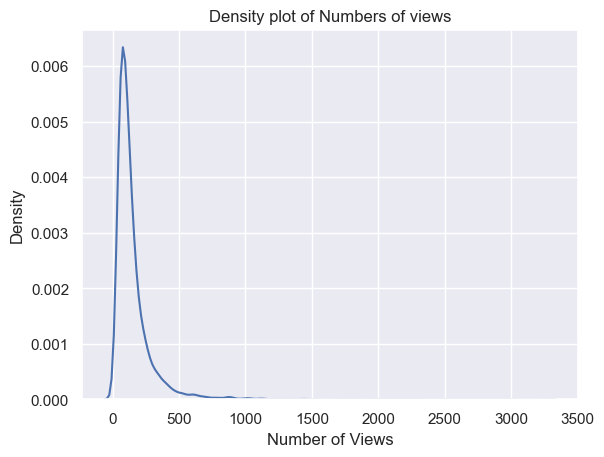

In [30]:
# Checking the Numbers of views closely
sns.kdeplot(x='Number of Views', data = cleaned_data)
plt.title('Density plot of Numbers of views')
plt.savefig('Density_plot_of_Numbers_of_views.png')

**Observation**
* The data is rightly skewed
* Most of the boat had between 0-500 views

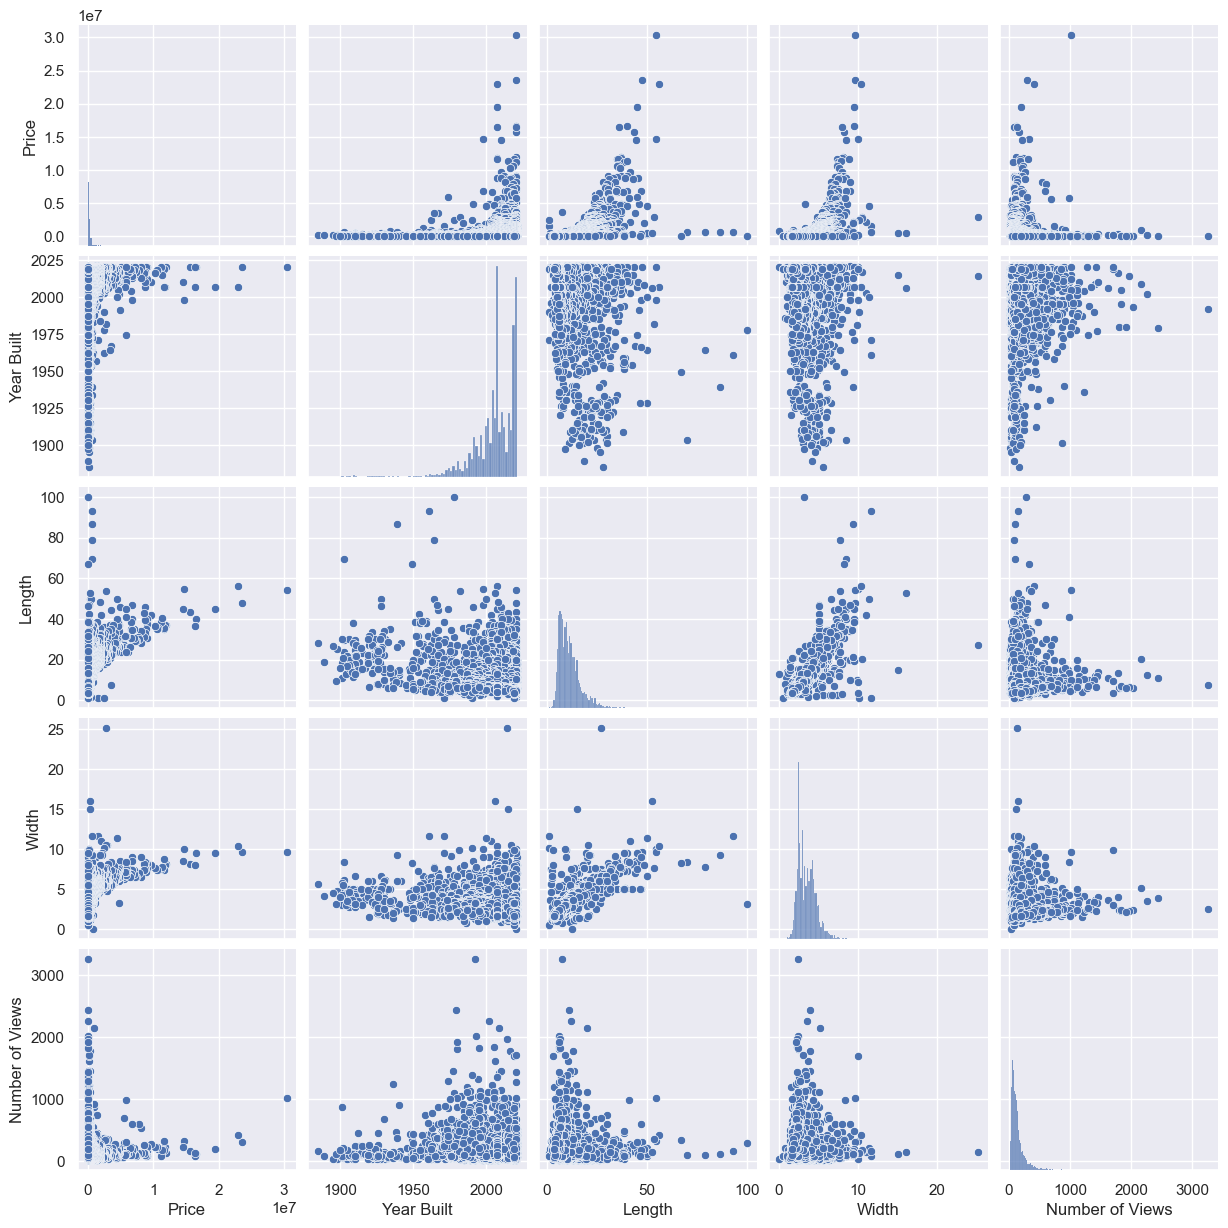

In [31]:
# Checking how all the numeric variables relate to each other
sns.pairplot(cleaned_data.select_dtypes(include='number'))
plt.show()

**Observation**  
* Year Built is leftly skewed
* All the numeric variables are weakly correlated to Number of views
* The correlation will be seen better through a correlation plot

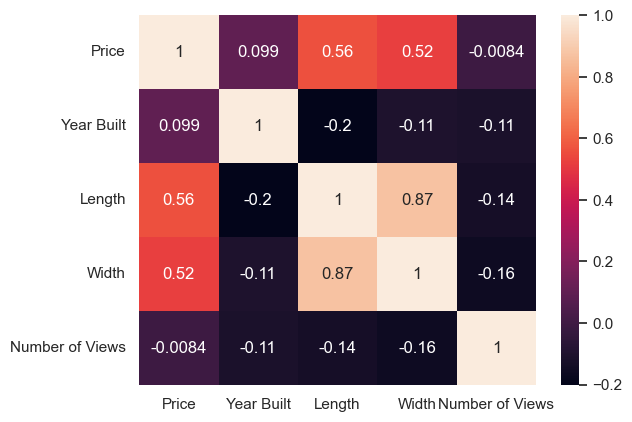

In [32]:
# Creating a correlation plot
sns.heatmap(cleaned_data.select_dtypes(include='number').corr(), annot = True)
plt.savefig('Correlation_plot')

**Observation**  
* The numeric data are weakly negatively correlated to Number of views
* The data are correlated to each other, the data are multicorrelated and must be decorrelated before using them to train the model
* The data contains outliers which must be removed before the model is trained

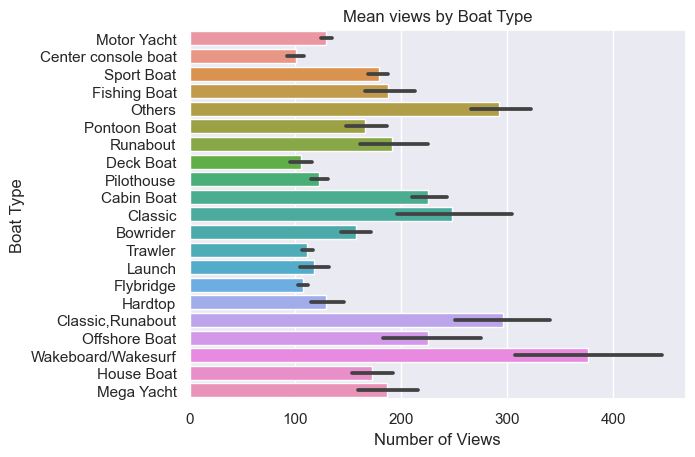

In [33]:
# Checking the distribution of views by Boat type
sns.barplot(y='Boat Type', x = 'Number of Views', data = cleaned_data)
plt.title('Mean views by Boat Type')
plt.savefig('Mean_views_by_Boat_Type.png')

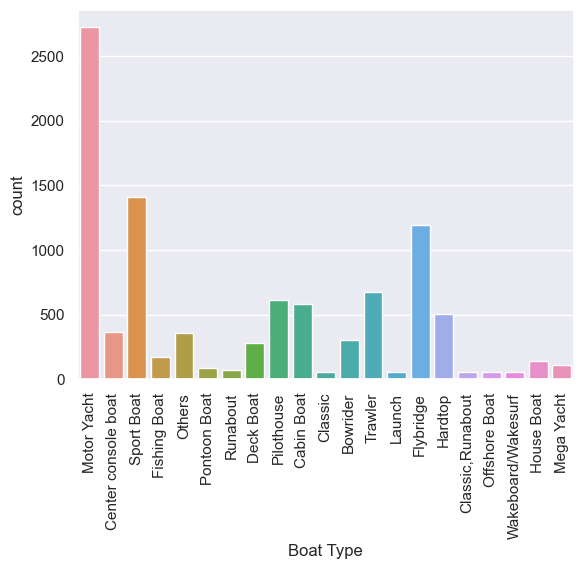

In [34]:
# Getting the counts of Boat Type
sns.countplot(x='Boat Type', data=cleaned_data)
plt.xticks(rotation = 90)
plt.show()

**Observation**
* The boat type with the most views are:
    * Wakeboard/wakesurf, classic Runabout and others
    * Although the counts of Flybridge is high, its views is low on average
* Listed boat with the highest count is Motor yacht

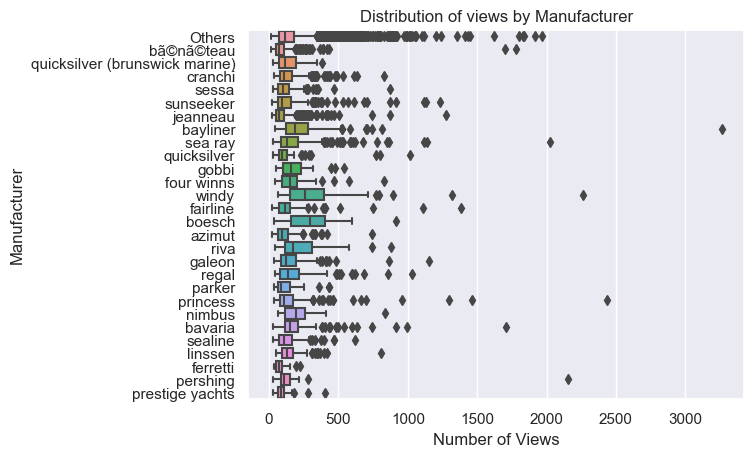

In [35]:
# Checking the distribution of views by Manufacturer
sns.boxplot(x='Number of Views', y = 'Manufacturer', data = cleaned_data)
plt.title('Distribution of views by Manufacturer')
plt.show()

**Observation**
* The Boats manufactured by riva has the highest views on average

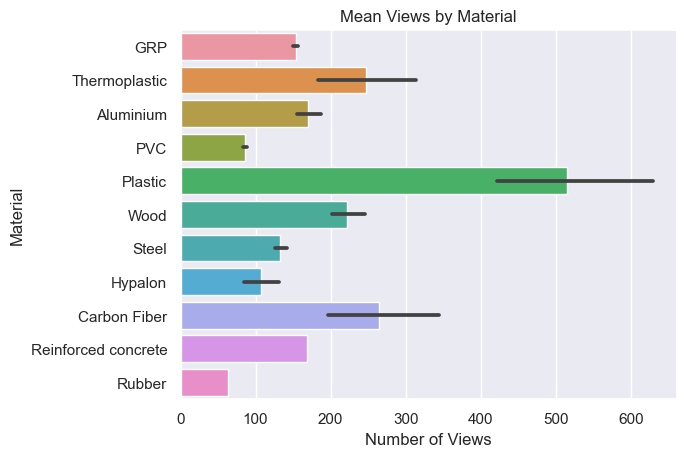

In [36]:
# Checking the mean number of views by Material
sns.barplot(y='Material', x = 'Number of Views', data = cleaned_data)
plt.title('Mean Views by Material')
plt.savefig('Mean_Views_by_Material.png')

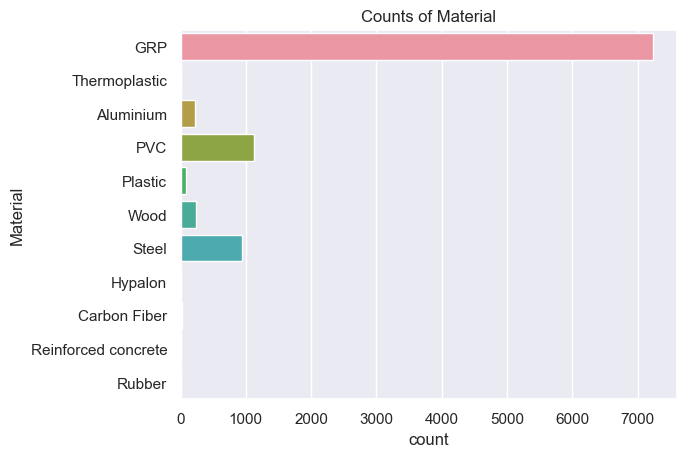

In [37]:
sns.countplot(y='Material', data = cleaned_data)
plt.title('Counts of Material')
plt.show()

**Observation**  
* Boats made from plastic has the highest views on average
* Boats made from rubber has the least views
* Most of the boats are made from GRP, PVC and Steel

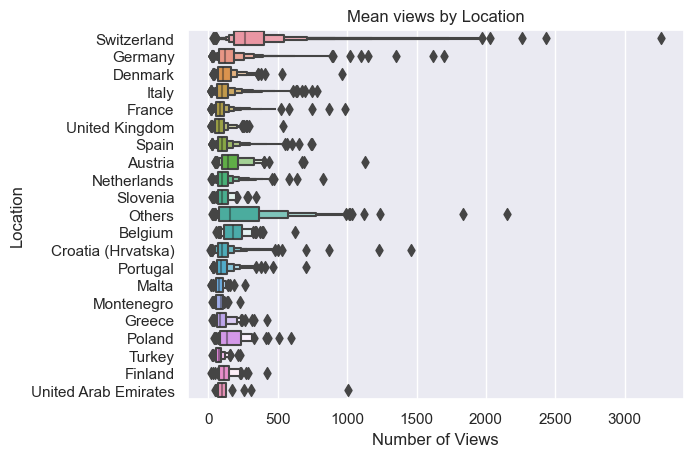

In [38]:
# Checking the mean views by Location
sns.boxenplot(y='Location', x = 'Number of Views', data = cleaned_data)
plt.title('Mean views by Location')
plt.show()

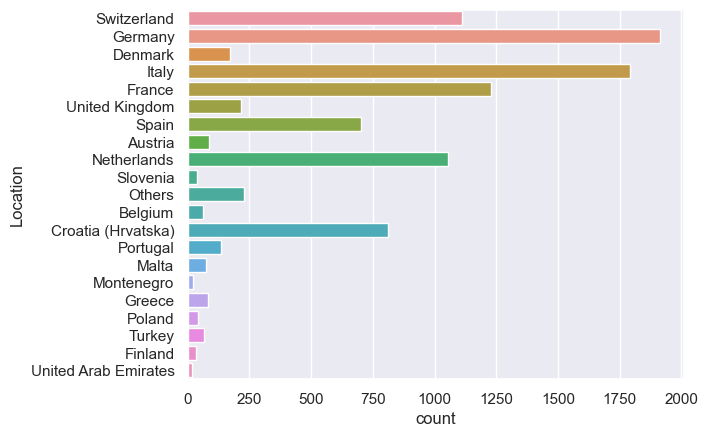

In [39]:
# Get the counts of Location
sns.countplot(y='Location', data = cleaned_data)
plt.show()

**Observation**
* Most of the boats are listed in germany
* Listed Boats in Switzerland has the highest views on average, while boats listed in Turkey has the least views on average

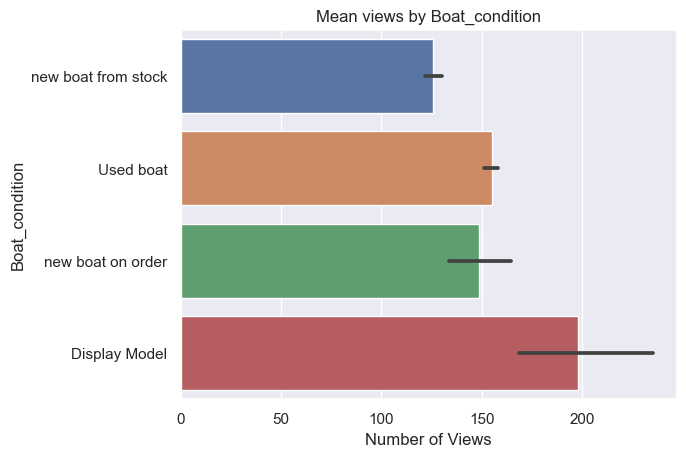

In [40]:
# Get the Mean views by Boat_condition
sns.barplot(y= 'Boat_condition', x='Number of Views', data= cleaned_data)
plt.title('Mean views by Boat_condition')
plt.savefig('Mean_views_by_Boat_condition.png')

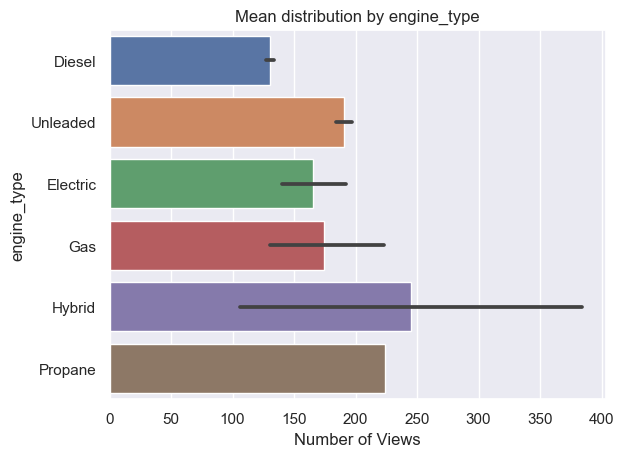

In [41]:
# Getting the mean views by engine_type
sns.barplot(y='engine_type', x = 'Number of Views', data = cleaned_data)
plt.title('Mean distribution by engine_type')
plt.savefig('Mean_distribution_by_engine_type.png')

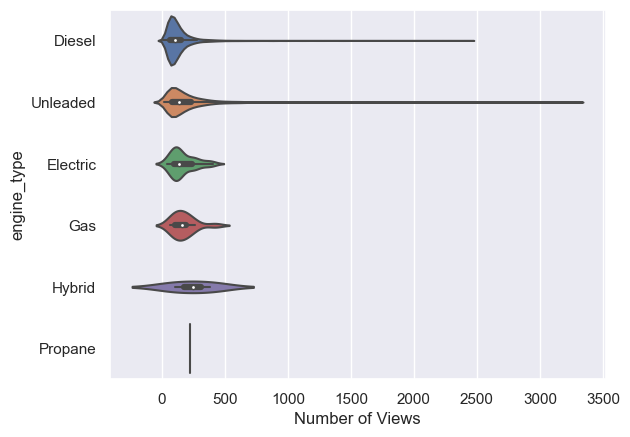

In [42]:
# Getting the mean views by engine_type
sns.violinplot(y='engine_type', x = 'Number of Views', data = cleaned_data)
plt.show()

**Observation**
* Boat_condition:
	* Display model has the highest view on average
* engine_type:
	* The Hybrid engine type has the highest view on average

## Summary
* The numeric data are weakly negatively correlated to Number of views
* The features are highly correlated to each other, hence must be decorrelated
* The data contains outliers which must be removed before the model is trained
* The boat type with the most views are Wakeboard/wakesurf, classic Runabout and others
* Although the counts of Flybridge is high, its views is low on average
* Listed boat with the highest count is Motor yacht
* The Boats manufactured by riva has the highest views on average
* Boats made from plastic has the highest views on average
* Boats made from rubber has the least views
* Most of the boats are made from GRP, PVC and Steel
* Most of the boats are listed in germany
* Listed Boats in Switzerland has the highest views on average, while boats listed in Turkey has the least views on average
* Boat_condition:
	* Display model has the highest view on average
* engine_type:
	* The Hybrid engine type has the highest view on average

# Data preprocessing
* Remove outliers from the data, we will keep the views with the 95% confidence interval of the data
* The data will be split into targets and inputs
* The categorical variable will be turned to numeric values using LabelEncoder
* The Data will be scaled using StandardScaler
* The data will be decorrelated using PCA
* The data will be split into train and test set

In [43]:
# Create a mask 
quantile_2, quantile_97 = cleaned_data['Number of Views'].quantile([0.025, 0.975])
mask = cleaned_data['Number of Views'].between(quantile_2, quantile_97)
# Filter the data
cleaned_data = cleaned_data[mask]
# Split the data into targets and inputs
targets = cleaned_data['Number of Views']
inputs = cleaned_data.drop('Number of Views', axis=1)
# Save the inputs name
inputs_names = inputs.columns

In [44]:
# Instantiate LabelEncoder
le = LabelEncoder()
# Iterate each categorical column and change the categories to labels
for col in inputs.select_dtypes(include='object').columns:
    inputs[col] = le.fit_transform(inputs[col])
# Instantiate StandardScaler as scaler
scaler = StandardScaler()
inputs = scaler.fit_transform(inputs)
# Instantiate PCA as pca
pca = PCA()
scaled_inputs = pca.fit_transform(inputs)

In [45]:
# Split the data into train and test set
inputs_train, inputs_test, targets_train, targets_test = train_test_split(
                                                                          scaled_inputs,
                                                                          targets,
                                                                          random_state=123,
                                                                          shuffle=True,
                                                                          test_size = 0.2
)

# Model Fitting
* Model will fitted using:
	* LinearRegression - This will be used as the baseline model because of its simplicity and very easy to understand
    * XGBRegressor - This chosen as the model because of its ability to create state-of-the-art machine learning and constantly outshines other models in terms of accuracy
    * GradientBoostingRegressor - This chosen because of its high accuracy and this estimator builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage a regression tree is fit on the negative gradient of the given loss function
* Model will be evaluated using:
	* Root_mean_squared_error : This metrics is very easy to understand, it represents the mean difference between the actual value and predicted value. It will be denoted as rmse
    * Mean_absolute_percentage_error : This metric represent the mean percentage error between the actual value and the predicted value. It will be denoted as MAPE
 	

In [46]:
# Instantiate the LinearRegression as baseline_model
baseline_model = LinearRegression()
# Train the model
baseline_model.fit(inputs_train, targets_train)
# Get the baseline_prediction
baseline_pred = baseline_model.predict(inputs_test)
# Get the rmse_score
baseline_rmse = round(mean_squared_error(targets_test, baseline_pred)**0.5, 2)
# Get the MAPE
baseline_MAPE = round(mean_absolute_percentage_error(targets_test, baseline_pred), 2)

In [47]:
print(f"The baseline rmse_score = {baseline_rmse}")
f"The baseline MAPE = {baseline_MAPE}"

The baseline rmse_score = 84.89


'The baseline MAPE = 0.62'

In [48]:
# Instantiate the GradientBoostingRegressor as gb_reg
gb_reg = GradientBoostingRegressor(
                                   max_depth = 1,
                                   subsample = 0.8,
                                   max_features = 0.2,
                                   n_estimators = 300,
                                   random_state = 123
)
gb_reg.fit(inputs_train, targets_train)

GradientBoostingRegressor(max_depth=1, max_features=0.2, n_estimators=300,
                          random_state=123, subsample=0.8)

In [49]:
# Get the gb_reg prediction
gb_reg_pred = gb_reg.predict(inputs_test)
# Get the rmse_score
gb_reg_rmse = round(mean_squared_error(targets_test, gb_reg_pred)**0.5, 2)
# Get the MAPE
gb_reg_MAPE = round(mean_absolute_percentage_error(targets_test, gb_reg_pred), 2)
print(f"The gb_reg rmse_score = {gb_reg_rmse}")
f"The gb_reg MAPE = {gb_reg_MAPE}"

The gb_reg rmse_score = 80.45


'The gb_reg MAPE = 0.58'

In [50]:
# Instantiate the XGBRegressor as xgb_reg
xgb_reg = xgb.XGBRegressor(objective = 'reg:linear', n_estimators = 10, seed = 123)
xgb_reg.fit(inputs_train, targets_train)

[10:58:18] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=10, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=123, reg_alpha=0, ...)

In [51]:
# Get the xgb_reg prediction
xgb_reg_pred = xgb_reg.predict(inputs_test)
# Get the rmse_score
xgb_reg_rmse = round(mean_squared_error(targets_test, xgb_reg_pred)**0.5, 2)
# Get the MAPE
xgb_reg_MAPE = round(mean_absolute_percentage_error(targets_test, xgb_reg_pred), 2)
print(f"The xgb_reg rmse_score = {xgb_reg_rmse}")
f"The xgb_reg MAPE = {xgb_reg_MAPE * 100}%"

The xgb_reg rmse_score = 78.17


'The xgb_reg MAPE = 51.0%'

**Observation**
* The best model in terms of mean_absolute_percentage error is xgb_reg
* The mean_absolute_percentage_error of 51% mean that the predicted number of views is 51% off the actual number of view.
* Let's Check if we can get a better score through hyper parameter tunning

# Hyperparameter Tunning
* RandomizedSearchCV - This will be used for the cross-validation.

In [52]:
xgb_cv = xgb.XGBRegressor()
xgb_param = {
             'learning_rate':  np.arange(0.05, 1.05, 0.05),
             'n_estimators' : [200],
             'subsample' : np.arange(0.05, 1.05, 0.05)
}
random_cv = RandomizedSearchCV(
                               estimator = xgb_cv,
                               param_distributions = xgb_param,
                               n_iter = 25,
                               scoring = 'neg_mean_squared_error',
                               cv=4,
                               verbose =1
)
random_cv.fit(inputs_train, targets_train)
print(f"The best validation score is {np.abs(random_cv.best_score_) ** 0.5}")

Fitting 4 folds for each of 25 candidates, totalling 100 fits
The best validation score is 78.56432792772195


In [53]:
best_model = random_cv.best_estimator_
best_pred = best_model.predict(inputs_test)
best_rmse = round((mean_squared_error(targets_test, best_pred) ** 0.5), 2)
best_MAPE = round(mean_absolute_percentage_error(targets_test, best_pred), 2)
print(f"The best rmse_score = {best_rmse}")
f"The best MAPE = {best_MAPE * 100}%"

The best rmse_score = 77.24


'The best MAPE = 53.0%'

In [54]:
# Creating a dataframe for the models
model_eval = pd.DataFrame()
model_eval['model_name'] = ['LinearRegression', 'GradientBoostingRegressor', 'XGBRegressor']
model_eval['rmse_score'] = [baseline_rmse, gb_reg_rmse, xgb_reg_rmse]
model_eval['MAPE_score'] = [baseline_MAPE, gb_reg_MAPE, xgb_reg_MAPE]
model_eval

,model_name,rmse_score,MAPE_score
0,LinearRegression,84.89,0.62
1,GradientBoostingRegressor,80.45,0.58
2,XGBRegressor,78.17,0.51


**Observation**  
* The best performing model is XGBRegressor
* The rmse_score of 78 meansthe mean difference between the predicted number of views and the actual views is 78
* The MAPE_score of 51% mean the mean percentage error between the predicted number of views and the actual views is 51%

# Feature Importance
* A dataFrame showing the Feature importance will be created
* Then a plot will be made showing the important features

In [55]:
feature_importance = pd.DataFrame()
feature_importance['feature_name'] = inputs_names
feature_importance['feature_importance'] = xgb_reg.feature_importances_
feature_importance = feature_importance.sort_values('feature_importance' ,ascending = False)
feature_importance

,feature_name,feature_importance
6,Price,0.227512
8,Length,0.144583
2,Material,0.121955
7,Year Built,0.117109
3,Location,0.103505
0,Boat Type,0.070507
4,Boat_condition,0.064148
1,Manufacturer,0.062489
9,Width,0.044332
5,engine_type,0.043860


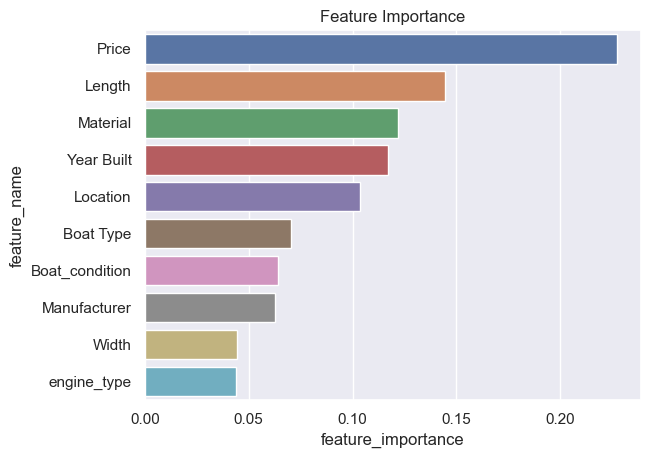

In [56]:
sns.barplot(y='feature_name', x = 'feature_importance', data = feature_importance)
plt.title('Feature Importance')
plt.savefig('Feature_Importance')

**Observation**
* The most important features are price, Length
* For the categorical variable; the most importance features are Material and Location

# Final Summary
* Since the model is to predict a continous variable(Number of views) this is a regression problem
* Models:
	* The best model is XGBRegressor, with a mean_absolute_percentage_error of 51% and root_mean_score of 78, that is the difference between the predicted views and the actual views is off by 51% on average, and the predicted views is off the actuals views by 7 vie8ws on average
* **Limitation:**
	* The model was not able to beat the 50% benchmark, but the accuracy of the model can be improved if better data was provided
* **Recommendation:**
	* Since material is a very important feature in predicting views, Materials that have little views on average should be prevented from being listed
    * Location that have little views on average should be prevented from being listed
    * Users of the website should be required to provide more data on boat to be listed which helps us in making further analysis and making models with higher predictions